<a href="https://colab.research.google.com/github/hiteshisawariya485/Signature_Verification/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, Activation, Add, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/DATASET'


In [ ]:
# Load and preprocess images
def load_data(image_size=(128, 128)):
    X, y = [], []
    for label, folder in enumerate(['full_forg', 'full_org']):
        folder_path = os.path.join(DATA_PATH, folder)
        for file in os.listdir(folder_path):
            path = os.path.join(folder_path, file)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, image_size)
            img = img / 255.0
            img = img.reshape((*image_size, 1))
            X.append(img)
            y.append(label)
    return np.array(X), to_categorical(np.array(y), num_classes=2)

X, y = load_data()

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

train_gen = datagen.flow(X_train, y_train, batch_size=16)
val_gen = datagen.flow(X_val, y_val, batch_size=16)

In [ ]:
# Define Residual Block for ResNet
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, strides= 1, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same', kernel_regularizer=l2(0.001))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


In [ ]:
#Build ResNet Model
def build_resnet(input_shape=(128, 128, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = residual_block(x, 32)
    x = residual_block(x, 64, stride=2)
    x = Dropout(0.3)(x)

    x = residual_block(x, 128, stride=2)
    x = Dropout(0.4)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_resnet()
optimizer = Adam(learning_rate=0.0001)

In [ ]:
# Compile Model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_7[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_8[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 128, 128,  │          0 │ add_3[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │     18,496 │ activation_9[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_10[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │      2,112 │ activation_9[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_13[0][0] 

 Total params: 326,082 (1.24 MB)

 Trainable params: 324,482 (1.24 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [ ]:
#Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)


In [ ]:
#Train Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.6623 - loss: 0.9394 - val_accuracy: 0.7076 - val_loss: 0.8991
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.6758 - loss: 0.9192 - val_accuracy: 0.7002 - val_loss: 0.9334
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.6675 - loss: 0.9144 - val_accuracy: 0.7188 - val_loss: 0.8764
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6700 - loss: 0.9208 - val_accuracy: 0.7169 - val_loss: 0.8773
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6937 - loss: 0.9001 - val_accuracy: 0.4916 - val_loss: 0.8875
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6861 - loss: 0.8802 - val_accuracy: 0.4916 - val_loss: 0.9013
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6573 - loss: 0.8861 - val_accuracy: 0.4916 - val_loss: 2.0620
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6955 - loss: 0.8624 -

In [ ]:
#Evaluate Model
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

Validation Accuracy: 70.58%
Validation Loss: 0.5774


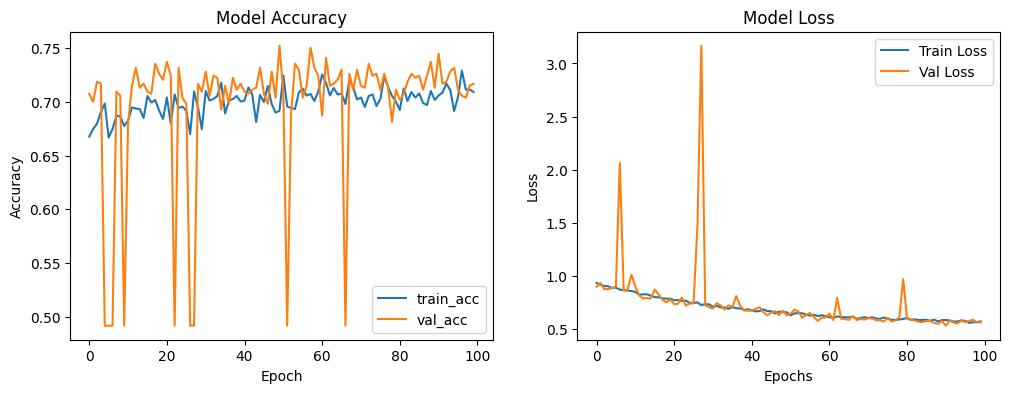

In [ ]:
# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns


In [ ]:
# Predict on Validation Data
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
# Get the true labels from y_val, using the indices from the validation generator
y_true = np.argmax(y_val[val_gen.index_array], axis=-1) if hasattr(val_gen, 'index_array') else np.argmax(y_val, axis=-1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


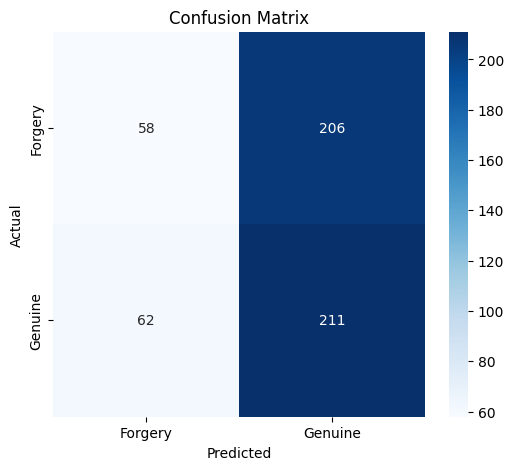

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forgery', 'Genuine'], yticklabels=['Forgery', 'Genuine'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Precision, Recall, F1 score
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.5060
Recall:    0.7729
F1 Score:  0.6116
